# Class 06: Data Transformation for Machine Learning

## Load Dataset

We'll use the Titanic dataset you're already familiar with.

In [1]:
import pandas as pd
import numpy as np

titanic = pd.read_csv('train.csv')

print(f"Dataset shape: {titanic.shape}")
titanic.head()

Dataset shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---

# Train/Test Split

Split data FIRST, before any transformation!

In [2]:
X = titanic.drop('Survived', axis=1) # inputs
y = titanic['Survived'] # output

In [3]:
print(f"Features: {X.shape}")
print(f"Target: {y.shape}")
print(f"Survival rate: {y.mean():.2%}")

Features: (891, 11)
Target: (891,)
Survival rate: 38.38%


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
 X,y,test_size=0.2,random_state=42, stratify=y
)

print(f"Training: {len(X_train)}")
print(f"Test: {len(X_test)}")
print(f"Train survival: {y_train.mean():.2%}")
print(f"Test survival: {y_test.mean():.2%}")

Training: 668
Test: 223
Train survival: 38.32%
Test survival: 38.57%


---

# Encoding Categorical Variables

In [17]:
X_train.select_dtypes(include='object').columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

## Label Encoding - Manual

In [19]:
mapping = {
    'male': 0,
    'female': 1
}

In [20]:
unique_values = X_train['Sex'].unique()
mapping = {val: idx for idx, val in enumerate(unique_values)}

print(f"Mapping: {mapping}")

Mapping: {'female': 0, 'male': 1}


In [21]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

X_train_enc['Sex'] = X_train['Sex'].map(mapping)
X_test_enc['Sex'] = X_test['Sex'].map(mapping)

In [ ]:
print("Before:", X_train['Sex'].head().values)
print("After:", X_train_enc['Sex'].head().values)

## Label Encoding - SkLearn

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [25]:
le.fit(X_train['Sex'])

LabelEncoder()

In [27]:
print(f"Learned classes: {le.classes_}")

Learned classes: ['female' 'male']


In [30]:
le.transform(['male', 'male', 'female',"female"])

array([1, 1, 0, 0])

In [31]:
X_train['Sex'] = le.transform(X_train['Sex'])
X_test['Sex'] = le.transform(X_test['Sex'])

print("After encoding:")
print(X_train['Sex'].head())

After encoding:
486    0
238    1
722    1
184    0
56     0
Name: Sex, dtype: int64


## One-Hot Encoding - Manual

In [33]:
categories = X_train['Embarked'].unique()
print(f"Categories: {categories}")

for cat in categories:
    col_name = f'Embarked_{cat}'
    X_train_enc[col_name] = (X_train['Embarked'] == cat).astype(int)
    X_test_enc[col_name] = (X_test['Embarked'] == cat).astype(int)

print("One-hot encoded:")
print(X_train_enc[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].tail())

Categories: ['S' 'C' 'Q' nan]
One-hot encoded:
    Embarked  Embarked_C  Embarked_Q  Embarked_S
547        C           1           0           0
469        C           1           0           0
736        S           0           0           1
462        S           0           0           1
821        S           0           0           1


In [34]:
# Drop first category (avoid dummy trap)
X_train_enc = X_train_enc.drop(['Embarked', 'Embarked_C'], axis=1)
X_test_enc = X_test_enc.drop(['Embarked', 'Embarked_C'], axis=1)

print("After dropping first category:")
print(X_train_enc[['Embarked_Q', 'Embarked_S']].tail())

After dropping first category:
     Embarked_Q  Embarked_S
547           0           0
469           0           0
736           0           1
462           0           1
821           0           1


## Using SkLearn

In [35]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False)

ohe.fit(X_train[['Embarked']])

,categories,'auto'
,drop,'first'
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [ ]:
embarked_train = ohe.transform(X_train[['Embarked']])
embarked_test = ohe.transform(X_test[['Embarked']])

embarked_train_c=embarked_train.copy()
embarked_test_c=embarked_test.copy()

embarked_train_df = pd.DataFrame(
    embarked_train,
    columns=ohe.get_feature_names_out(),
    index=X_train.index
)

embarked_test_df = pd.DataFrame(
    embarked_test,
    columns=ohe.get_feature_names_out(),
    index=X_test.index
) #converting array to dataframe
print(embarked_train_df)

     Embarked_Q  Embarked_S  Embarked_nan
486         0.0         1.0           0.0
238         0.0         1.0           0.0
722         0.0         1.0           0.0
184         0.0         1.0           0.0
56          0.0         1.0           0.0
..          ...         ...           ...
547         0.0         0.0           0.0
469         0.0         0.0           0.0
736         0.0         1.0           0.0
462         0.0         1.0           0.0
821         0.0         1.0           0.0

[668 rows x 3 columns]


---

# Feature Scaling

## StandardScaler - Manual

In [41]:
age_mean = X_train['Age'].mean()
age_std = X_train['Age'].std()

print(f"Age: mean={age_mean:.2f}, std={age_std:.2f}")

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled['Age'] = (X_train['Age'] - age_mean) / age_std
X_test_scaled['Age'] = (X_test['Age'] - age_mean) / age_std

print("After scaling:")
print(X_train_scaled['Age'].describe())

Age: mean=29.93, std=14.46
After scaling:
count    5.370000e+02
mean    -3.307927e-18
std      1.000000e+00
min     -2.041500e+00
25%     -6.178677e-01
50%     -6.446337e-02
75%      6.272921e-01
max      3.463490e+00
Name: Age, dtype: float64


## Using sklearn StandardScaler

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[['Age', 'Fare']])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['Age', 'Fare']] = scaler.transform(X_train[['Age', 'Fare']])
X_test_scaled[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

print(f"Learned: mean={scaler.mean_}, std={scaler.scale_}")

Learned: mean=[29.93188082 31.17746946], std=[14.44250917 47.42234123]


## MinMaxScaler - Manual

In [43]:
age_min = X_train['Age'].min()
age_max = X_train['Age'].max()

X_train_minmax = X_train.copy()
X_train_minmax['Age'] = (X_train['Age'] - age_min) / (age_max - age_min)

print(f"Age range: [{age_min}, {age_max}]")
print(f"Scaled to [0, 1]:")
print(X_train_minmax['Age'].describe())

Age range: [0.42, 80.0]
Scaled to [0, 1]:
count    537.000000
mean       0.370845
std        0.181653
min        0.000000
25%        0.258608
50%        0.359135
75%        0.484795
max        1.000000
Name: Age, dtype: float64


---

# Handling Imbalanced Data

Class distribution:
Survived
0    412
1    256
Name: count, dtype: int64
Died: 61.7%
Survived: 38.3%


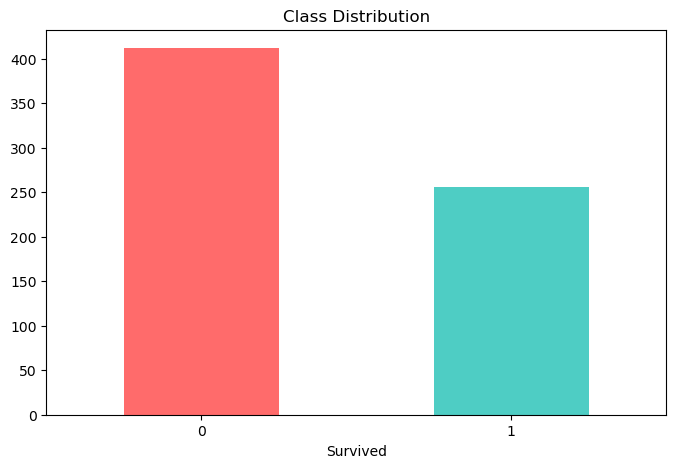

In [44]:
import matplotlib.pyplot as plt

print("Class distribution:")
print(y_train.value_counts())
print(f"Died: {(y_train==0).mean():.1%}")
print(f"Survived: {(y_train==1).mean():.1%}")

plt.figure(figsize=(8, 5))
y_train.value_counts().plot(kind='bar', color=['#ff6b6b', '#4ecdc4'])
plt.title('Class Distribution')
plt.xticks(rotation=0)
plt.show()

## Undersampling

In [45]:
died_idx = y_train[y_train == 0].index
survived_idx = y_train[y_train == 1].index

print(f"Died: {len(died_idx)}, Survived: {len(survived_idx)}")

Died: 412, Survived: 256


In [48]:
np.random.seed(42)
died_undersampled = np.random.choice(died_idx, size=len(survived_idx), replace=False)


In [49]:
balanced_idx = np.concatenate([died_undersampled, survived_idx])

In [51]:
X_train_balanced = X_train.loc[balanced_idx]
y_train_balanced = y_train.loc[balanced_idx]

print(f"After undersampling: {len(y_train_balanced)} samples")
print(f"Class 0: {(y_train_balanced==0).sum()}")
print(f"Class 1: {(y_train_balanced==1).sum()}")

After undersampling: 512 samples
Class 0: 256
Class 1: 256


## Class Weights - Manual Calculation

In [54]:
n_samples = len(y_train)
n_classes = 2
n_died = (y_train == 0).sum()
n_survived = (y_train == 1).sum()

In [55]:
weight_died = 1
weight_survived = n_died / n_survived

print(f"Class 0 weight: {weight_died:.3f}")
print(f"Class 1 weight: {weight_survived:.3f}")

Class 0 weight: 1.000
Class 1 weight: 1.609


In [56]:
weight_died = n_samples / (n_classes * n_died)
weight_survived = n_samples / (n_classes * n_survived)

print(f"Class 0 weight: {weight_died:.3f}")
print(f"Class 1 weight: {weight_survived:.3f}")
print(f"\nRatio: {weight_survived/weight_died:.2f}:1")

Class 0 weight: 0.811
Class 1 weight: 1.305

Ratio: 1.61:1


In [57]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

print(f"Class weights: {class_weights}")


Class weights: [0.81067961 1.3046875 ]
